In [3]:
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
from paper_changes import *
# manual feature selection
from collections import defaultdict
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.decomposition import SparsePCA
from scipy.stats import zscore

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
import pickle
import pandas as pd

def load_data(field='relative', zscore=True):
    infile = '/userdata/pdaly/supereeg/results/samp100_2h_54pid_pos-1.18.power.pkl'
    data = pickle.load(open(infile, 'rb'))
    labels = pd.read_csv('/home/kscangos/Sandbox/full_patient_list_pd_feb.csv', index_col=0)
    labels['pid'] = labels.index.map(lambda pid: pid[2:])
    df = data[field]
    df = df.reset_index().merge(labels[['pid', 'dep']], left_on='index',
                           right_on='pid').set_index('index').drop('pid', axis=1)
    df.rename(columns={'Dep': 'dep'}, inplace=True)
    df.drop(['92','111','119','131','135','27','115','130',
             '144','158','162','170','183'], axis=0, inplace=True)
    X, y = df.drop('dep', axis=1), df.dep
    if zscore:
        X = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns, index=X.index)
    return X, y

In [5]:
class Metrics:
    '''would dod this for test, but don't want to rewrite it'''
    def __init__(self):
        self.recalls = list()
        self.precisions = list()
        self.accuracies = list()
        self.balanced_accuracies = list()
        self.rocs = list()
    
    def add_results(self, actual, preds, probs):
        self.recalls.append(recall_score(actual, preds))
        self.precisions.append(precision_score(actual, preds))
        self.accuracies.append(accuracy_score(actual, preds))
        self.balanced_accuracies.append(balanced_accuracy_score(actual, preds))
        self.rocs.append(roc_auc_score(actual, probs))
    
    def avg_all(self):
        self.avgs = pd.Series({
            'recall': np.mean(self.recalls),
            'precision': np.mean(self.precisions),
            'accuracy': np.mean(self.accuracies),
            'balanced_accuracy': np.mean(self.balanced_accuracies),
            'roc': np.mean(self.rocs)})
        self.recall = self.avgs.recall
        self.precision = self.avgs.precision
        self.accuracy = self.avgs.accuracy
        self.balanced_accuracy = self.avgs.balanced_accuracy
        self.roc = self.avgs.roc

In [6]:
def crossval(X, y, pipe, get_feats, ite=100, verbose=True, null=False):
    feats = defaultdict(list)
    preds = list()
    probs = list()
    model = 'logit'
    trm = Metrics()
    ys = list()
    for _ in tqdm(range(ite)) if verbose else range(ite):
        if null:
            y = y.sample(frac=1)
        ys.extend(y)
        for train_idx, test_idx in LeaveOneOut().split(X):
            pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
            trm.add_results(y.iloc[train_idx],
                pipe.predict(X.iloc[train_idx]), 
                pipe.predict_proba(X.iloc[train_idx])[:, 1])
            pred = pipe.predict(X.iloc[test_idx])[0]
            proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
            preds.append(pred)
            probs.append(proba)
            fs = get_feats(pipe)
            for f in fs.index:
                if abs(fs[f]) > 0:
                    feats[f].append(fs[f])
    bm = pd.DataFrame(list(zip(preds, probs, ys)), 
                      columns=['pred', 'proba', 'actual'])
    trm.avg_all()
    return bm, trm, feats


def print_res(bm, trm, model='logit'):
    rs = recall_score(bm['actual'], bm['pred'])
    ps = precision_score(bm['actual'], bm['pred'])
    acc = accuracy_score(bm['actual'], bm['pred'])
    bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
    roc = roc_auc_score(bm['actual'], bm['proba'])
    
    results = trm.avgs.to_frame().rename(columns={0: 'train'})
    results['test'] = 0
    results.loc['accuracy', 'test'] = acc
    results.loc['balanced_accuracy', 'test'] = bacc
    results.loc['precision', 'test'] = ps
    results.loc['recall', 'test'] = rs
    results.loc['roc', 'test'] = roc
    
    print(results.round(3))
    
    
def plot_res(feats):
    fig, axs = plt.subplots(1, 2, figsize=(14, 4))

    fsrs['count'].apply(lambda v: v/4000).plot(kind='bar', ax=axs[0]);
    axs[0].set_ylabel('Percent of Models w/ Feature')
    fsrs['mean'].plot(kind='bar', yerr=fsrs['std'], ax=axs[1])
    axs[1].set_ylabel('Avg Model Weight')

    sns.despine()

### CV: PCA(10) / Logit

100%|██████████| 1/1 [00:00<00:00,  3.03it/s]


                   train   test
accuracy           0.813  0.780
balanced_accuracy  0.811  0.774
precision          0.840  0.792
recall             0.825  0.826
roc                0.874  0.758
           mean       std  count
pc_1   0.056643  0.021148     41
pc_10  0.391591  0.003987      2
pc_2   0.122495  0.044753     41
pc_3  -0.601441  0.182362     41
pc_4   0.175326  0.107674     40
pc_5  -0.403649  0.414344      3
pc_6  -1.109649  0.196183     40
pc_8   0.299305  0.000000      1


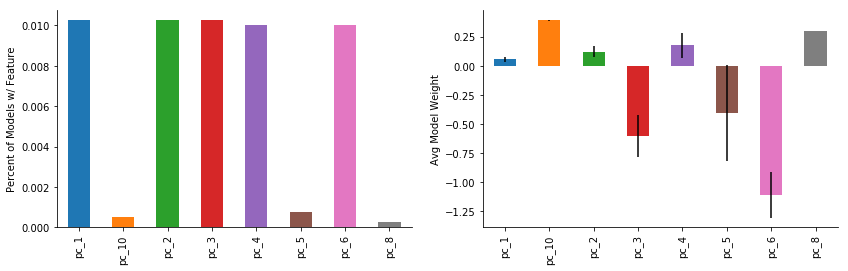

In [7]:
X, y = load_data()

pipe = Pipeline([('pca', PCA()),
                 ('clf', LogisticRegression(C=0.75, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100))])
             
get_feats = lambda pipe: pd.Series(np.squeeze(pipe.steps[-1][1].coef_), 
                                   index=['pc_' + str(i+1) for i in range(X.shape[1])])

bm, trm, feats = crossval(X, y, pipe, get_feats, ite=1)

print_res(bm, trm)

fsrs = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs)

plot_res(feats)

In [8]:
accuracy = 0.78

## Null

100%|██████████| 1000/1000 [05:03<00:00,  3.30it/s]


                   train   test
accuracy           0.705  0.503
balanced_accuracy  0.708  0.503
precision          0.768  0.564
recall             0.682  0.501
roc                0.782  0.504
           mean       std  count
pc_1  -0.002188  0.083201  37686
pc_10 -0.007002  0.613819  11327
pc_11  0.060768  0.680114   8243
pc_12 -0.035151  0.673344   6927
pc_13  0.009024  0.604447   4609
pc_14 -0.008813  0.761958   3188
pc_15 -0.049910  0.825729   2225
pc_16 -0.023609  0.848842   1089
pc_17 -0.040307  0.692296    118
pc_18 -0.030969  0.701943     64
pc_19  0.193132  0.522051     25
pc_2   0.011223  0.130575  35861
pc_3   0.006156  0.195020  34895
pc_4   0.022101  0.222501  31082
pc_5   0.012751  0.456021  22113
pc_6   0.005542  0.494546  20340
pc_7  -0.036334  0.561055  17262
pc_8  -0.014471  0.575729  14996
pc_9  -0.009053  0.570987  13038


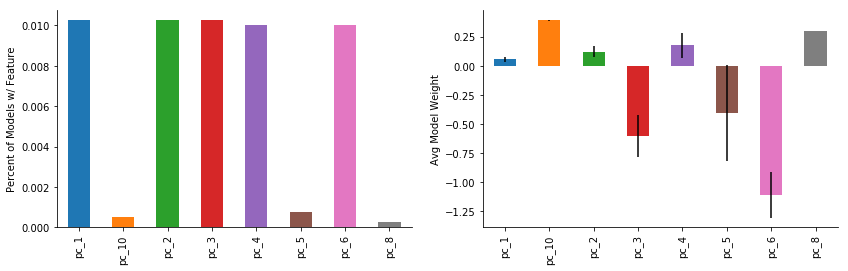

In [9]:
X, y = load_data()

pipe = Pipeline([('pca', PCA()),
                 ('clf', LogisticRegression(C=0.75, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=100))])

bm_null, trm_null, feats_null = crossval(X, y, pipe, get_feats, ite=1000, null=True)

print_res(bm_null, trm_null)

fsrs_null = pd.DataFrame.from_dict({v: [np.mean(l), np.std(l), len(l)] for v, l in feats_null.items()},
                              columns=['mean', 'std', 'count'], orient='index').sort_index()
print(fsrs_null)

plot_res(feats_null)

In [12]:
# t test vs null
from rsd.utils import chunker

null = {'bac': list(),
        'acc': list(),
        'rec': list(),
        'prec': list(),
        'auc': list()}

for ch in chunker(bm_null, 41):
    null['bac'].append(balanced_accuracy_score(ch['actual'], ch['pred']))
    null['acc'].append(accuracy_score(ch['actual'], ch['pred']))
    null['rec'].append(recall_score(ch['actual'], ch['pred']))
    null['prec'].append(precision_score(ch['actual'], ch['pred']))
    null['auc'].append(roc_auc_score(ch['actual'], ch['proba']))
    

In [13]:
len(null['acc'])

1000

In [19]:
sum(n >= accuracy for n in null['acc']) / len(null['acc'])

0.002

In [15]:
accuracy

0.78

In [16]:
pd.Series(null['acc']).describe()

count    1000.000000
mean        0.502854
std         0.101164
min         0.097561
25%         0.439024
50%         0.512195
75%         0.560976
max         0.780488
dtype: float64

In [17]:
pd.Series(null['rec']).describe()

count    1000.000000
mean        0.500826
std         0.111411
min         0.086957
25%         0.434783
50%         0.521739
75%         0.565217
max         0.826087
dtype: float64